# Fitbit

In [198]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np

In [199]:
cmap='rocket'
sns.set_palette(sns.color_palette(cmap))

In [200]:
# loading the data
infile = open('data/daily_fitbit_sema_df_unprocessed.pkl','rb')
fitbit = pickle.load(infile)
infile.close()
fitbit.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,step_goal,min_goal,max_goal,step_goal_label,HAPPY,NEUTRAL,TENSE/ANXIOUS,HOME,OUTDOORS,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
list(fitbit)

['id',
 'date',
 'nightly_temperature',
 'nremhr',
 'rmssd',
 'spo2',
 'full_sleep_breathing_rate',
 'stress_score',
 'sleep_points_percentage',
 'exertion_points_percentage',
 'responsiveness_points_percentage',
 'daily_temperature_variation',
 'badgeType',
 'calories',
 'filteredDemographicVO2Max',
 'distance',
 'activityType',
 'bpm',
 'lightly_active_minutes',
 'moderately_active_minutes',
 'very_active_minutes',
 'sedentary_minutes',
 'mindfulness_session',
 'scl_avg',
 'resting_hr',
 'sleep_duration',
 'minutesToFallAsleep',
 'minutesAsleep',
 'minutesAwake',
 'minutesAfterWakeup',
 'sleep_efficiency',
 'sleep_deep_ratio',
 'sleep_wake_ratio',
 'sleep_light_ratio',
 'sleep_rem_ratio',
 'steps',
 'minutes_in_default_zone_1',
 'minutes_below_default_zone_1',
 'minutes_in_default_zone_2',
 'minutes_in_default_zone_3',
 'age',
 'gender',
 'bmi',
 'step_goal',
 'min_goal',
 'max_goal',
 'step_goal_label',
 'HAPPY',
 'NEUTRAL',
 'TENSE/ANXIOUS',
 'HOME',
 'OUTDOORS',
 'WORK/SCHOOL']

In [202]:
# selecting experiment days
fitbit = fitbit.sort_values(by='date', ascending=True)
fitbit['date'] = pd.to_datetime(fitbit['date'].astype("str"), format='%Y-%m-%d')
fitbit1 = fitbit[(fitbit['date'] >= "2021-05-24") & (fitbit['date'] <= "2021-07-26")] #Round1
fitbit2 = fitbit[(fitbit['date'] >= "2021-11-15") & (fitbit['date'] <= "2022-01-17")] #Round2
fitbit=pd.concat([fitbit1, fitbit2], ignore_index=True)
fitbit

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,step_goal,min_goal,max_goal,step_goal_label,HAPPY,NEUTRAL,TENSE/ANXIOUS,HOME,OUTDOORS,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,621e301e67b776a240608a72,2021-05-24,34.710232,NaN,NaN,NaN,NaN,74.0,0.700000,0.700,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,621e301367b776a24057738e,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,621e360b67b776a24039709f,2021-05-24,NaN,68.321,31.413,NaN,15.4,69.0,0.633333,0.650,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,621e2fce67b776a240279baa,2021-05-24,34.783747,83.170,15.941,96.6,15.2,70.0,0.733333,0.725,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902,621e30e267b776a240e5bf90,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4903,621e322367b776a240e44e9b,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4904,621e300767b776a2404dc717,2022-01-17,33.186399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4905,621e2f1b67b776a240b3d87c,2022-01-17,34.404580,65.782,23.793,NaN,16.0,72.0,0.766667,0.725,...,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
# keep only fitbit stress score (daily granularity)
fitbit_stress=fitbit[['id', 'date','stress_score']]
fitbit_stress.head()

,id,date,stress_score
0,621e2e8e67b776a24055b564,2021-05-24,78.0
1,621e301e67b776a240608a72,2021-05-24,74.0
2,621e301367b776a24057738e,2021-05-24,NaN
3,621e360b67b776a24039709f,2021-05-24,69.0
4,621e2fce67b776a240279baa,2021-05-24,70.0


<AxesSubplot:>

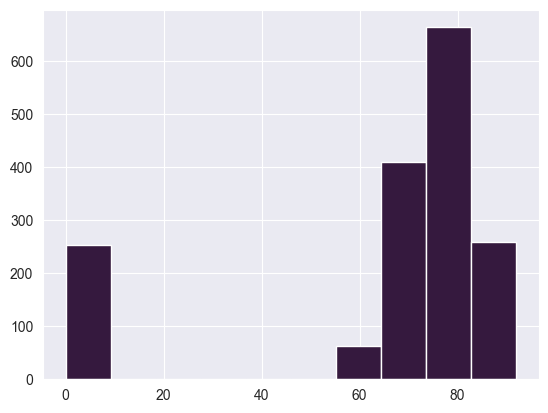

In [204]:
fitbit_stress['stress_score'].hist()

In [205]:
# handle nans
fitbit_stress['stress_score'].isna().sum()

3261

In [206]:
#fitbit_stress = fitbit_stress.fillna(0.0)
fitbit_stress=fitbit_stress.dropna()
fitbit_stress['stress_score'].isna().sum()

0

In [207]:
# delete 0.0 values? outliers? corrupted data?
fitbit_stress=fitbit_stress.loc[(fitbit_stress['stress_score'] > 40)]

<AxesSubplot:>

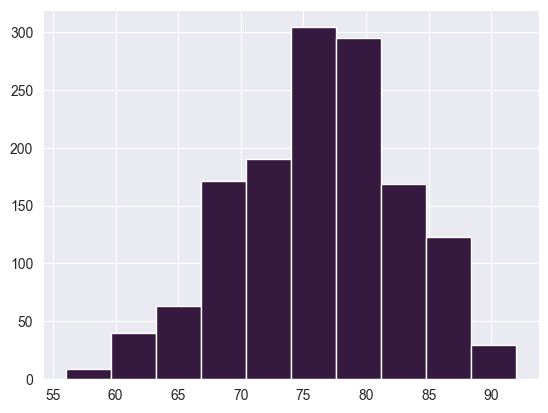

In [208]:
fitbit_stress['stress_score'].hist()

In [209]:
fitbit_stress

,id,date,stress_score
0,621e2e8e67b776a24055b564,2021-05-24,78.0
1,621e301e67b776a240608a72,2021-05-24,74.0
3,621e360b67b776a24039709f,2021-05-24,69.0
4,621e2fce67b776a240279baa,2021-05-24,70.0
11,621e2f3967b776a240c654db,2021-05-24,76.0
...,...,...,...
4883,621e346f67b776a24081744f,2022-01-17,72.0
4888,621e32e667b776a2406d2f1c,2022-01-17,75.0
4897,621e2f9167b776a240011ccb,2022-01-17,76.0
4901,621e339967b776a240e502de,2022-01-17,84.0


# Semas

In [210]:
# loading the complete dataframe
infile = open('data/sema_stress_read_from_the_base_experiment_dates.pkl','rb')
semas = pickle.load(infile)
infile.close()
semas.head()

,user_id,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED
0,621e362467b776a2404ad513,2021-05-24,0,1,0,0,0,0,0
1,621e34ca67b776a240be3b69,2021-05-24,0,0,0,0,0,0,1
2,621e32d967b776a240627414,2021-05-24,0,0,0,1,0,0,0
3,621e30e467b776a240e817c7,2021-05-24,0,0,0,0,0,1,0
4,621e36f967b776a240e5e7c9,2021-05-24,0,0,0,0,0,0,1


In [211]:
# handle nans
semas.isna().sum()

user_id           0
date              0
ALERT             0
HAPPY             0
NEUTRAL           0
RESTED/RELAXED    0
SAD               0
TENSE/ANXIOUS     0
TIRED             0
dtype: int64

In [212]:
semas_stress=semas.groupby(['user_id','date'])['ALERT','HAPPY','NEUTRAL','RESTED/RELAXED','SAD','TENSE/ANXIOUS','TIRED'].sum().reset_index()

C:\Users\Christina\AppData\Local\Temp\ipykernel_45196\368138546.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  semas_stress=semas.groupby(['user_id','date'])['ALERT','HAPPY','NEUTRAL','RESTED/RELAXED','SAD','TENSE/ANXIOUS','TIRED'].sum().reset_index()


In [213]:
semas_stress = semas_stress.sort_values(by='date', ascending=True)
semas_stress

,user_id,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED
1348,621e32d967b776a240627414,2021-05-24,0,0,0,1,0,0,0
1983,621e362467b776a2404ad513,2021-05-24,0,3,0,0,0,0,0
569,621e301e67b776a240608a72,2021-05-24,0,0,0,1,0,0,0
724,621e30e467b776a240e817c7,2021-05-24,0,0,0,0,0,1,0
1826,621e34ca67b776a240be3b69,2021-05-24,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
1611,621e339967b776a240e502de,2022-01-16,0,1,0,0,0,0,0
381,621e2f9167b776a240011ccb,2022-01-17,0,0,0,0,0,1,0
825,621e30f467b776a240f22944,2022-01-17,0,0,1,0,0,0,0
1825,621e346f67b776a24081744f,2022-01-17,0,0,0,0,0,1,0


In [214]:
# grouping the emotions
semas_stress['positive feelings'] = semas_stress['HAPPY'] + semas_stress['RESTED/RELAXED'] + semas_stress['NEUTRAL']
semas_stress['negative feelings'] =semas_stress['ALERT'] + semas_stress['SAD'] + semas_stress['TENSE/ANXIOUS'] + semas_stress['TIRED']

In [215]:
semas_stress=semas_stress.reset_index()
semas_stress=semas_stress.drop(['index'], axis=1)
semas_stress

,user_id,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,positive feelings,negative feelings
0,621e32d967b776a240627414,2021-05-24,0,0,0,1,0,0,0,1,0
1,621e362467b776a2404ad513,2021-05-24,0,3,0,0,0,0,0,3,0
2,621e301e67b776a240608a72,2021-05-24,0,0,0,1,0,0,0,1,0
3,621e30e467b776a240e817c7,2021-05-24,0,0,0,0,0,1,0,0,1
4,621e34ca67b776a240be3b69,2021-05-24,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2240,621e339967b776a240e502de,2022-01-16,0,1,0,0,0,0,0,1,0
2241,621e2f9167b776a240011ccb,2022-01-17,0,0,0,0,0,1,0,0,1
2242,621e30f467b776a240f22944,2022-01-17,0,0,1,0,0,0,0,1,0
2243,621e346f67b776a24081744f,2022-01-17,0,0,0,0,0,1,0,0,1


In [216]:
semas_stress=semas_stress.rename(columns={"user_id": "id"})

In [217]:
stress=fitbit_stress.merge(semas_stress,on=['date','id'])
stress

,id,date,stress_score,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,positive feelings,negative feelings
0,621e301e67b776a240608a72,2021-05-24,74.0,0,0,0,1,0,0,0,1,0
1,621e2f3967b776a240c654db,2021-05-24,76.0,0,0,0,1,0,0,0,1,0
2,621e36f967b776a240e5e7c9,2021-05-24,83.0,0,0,0,0,0,1,1,0,2
3,621e32af67b776a24045b4cf,2021-05-24,79.0,0,0,0,0,1,0,0,0,1
4,621e337667b776a240ce78ab,2021-05-24,60.0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
902,621e339967b776a240e502de,2022-01-16,73.0,0,1,0,0,0,0,0,1,0
903,621e2f1b67b776a240b3d87c,2022-01-16,76.0,0,0,1,0,0,0,0,1,0
904,621e2f9167b776a240011ccb,2022-01-16,76.0,0,0,0,0,0,2,0,0,2
905,621e346f67b776a24081744f,2022-01-17,72.0,0,0,0,0,0,1,0,0,1


<AxesSubplot:>

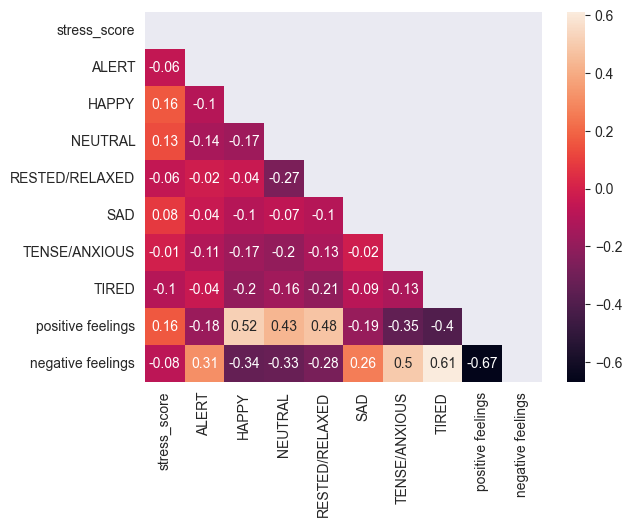

In [218]:
correlation_matrix = stress.corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, annot=True,cmap=cmap,mask=mask)

In [219]:
from dataprep.eda import create_report
create_report(stress).show_browser()

  0%|          | 0/1175 [00:00<?, ?it/s]

C:\Users\Christina\AppData\Roaming\Python\Python39\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))


In [220]:
from pandas_profiling import ProfileReport
profile = ProfileReport(stress, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

checking other features as well

<AxesSubplot:>

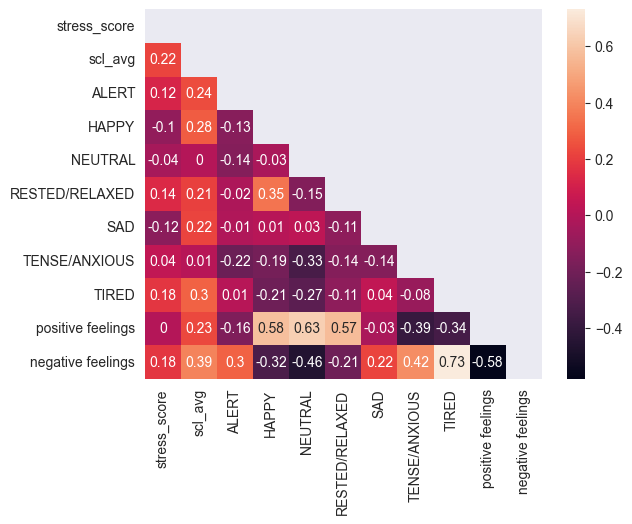

In [221]:
fitbit_new=fitbit[['id', 'date','stress_score','scl_avg']]
fitbit_new=fitbit_new.dropna()
df_new=fitbit_new.merge(semas_stress,on=['date','id'])
df_new=df_new.dropna()

correlation_matrix = df_new.corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, annot=True,cmap=cmap,mask=mask)